## Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import sensemakr as smkr
import warnings

warnings.filterwarnings('ignore')

## Generate simulated data

In [2]:
def gen_sim_data(
    n       = 1000,
    sd_x    = 1,
    sd_z    = 1,
    beta_d  = 0,
    beta_dx = 0.54,
    beta_dz = 0.405,
    sd_d    = 0.8,
    beta_y  = 0,
    beta_yd = 0.025,
    beta_yx = 0.57,
    beta_yz = 0.38,
    sd_y    = 0.8
):
    np.random.seed(1)
    x = np.random.normal(0, sd_x, size=n)
    z = np.random.normal(0, sd_z, size=n)
    d = beta_d             + beta_dx*x + beta_dz*z + np.random.normal(0, sd_d, size=n)
    y = beta_y + beta_yd*d + beta_yx*x + beta_yz*z + np.random.normal(0, sd_y, size=n)
    df = pd.DataFrame({'Y': y, 'D': d, 'X': x, 'Z': z})
    return df

In [3]:
df = gen_sim_data()

print(df.shape)
df.head()

(1000, 4)


,Y,D,X,Z
0,0.836129,1.206699,1.624345,-0.153236
1,-1.134906,-1.124478,-0.611756,-2.432509
2,0.669984,-0.437969,-0.528172,0.507984
3,0.381499,-1.199272,-1.072969,-0.324032
4,0.297464,-1.768622,0.865408,-1.511077


## Fit regression models to data

In [4]:
def fit_reg(formula, data):
    mod = smf.ols(formula=formula, data=data)
    res = mod.fit()
    return res

In [5]:
# fit all regression models that we'll use later

res_ydxz = fit_reg(formula='Y ~ D + X + Z', data=df)
res_ydx  = fit_reg(formula='Y ~ D + X',     data=df)
res_dxz  = fit_reg(formula='D ~ X + Z',     data=df)
res_dx   = fit_reg(formula='D ~ X',         data=df)

In [6]:
res_ydx.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.368
No. Observations:                1000   F-statistic:                     291.3
Covariance Type:            nonrobust   Prob (F-statistic):          2.33e-100
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0123      0.028      0.440      0.660      -0.042       0.067
D              0.2686      0.032      8.389      0.000       0.206       0.331
X              0.5058      0.033     15.450      0.000       0.442       0.570
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
res_ydxz.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.470
No. Observations:                1000   F-statistic:                     296.3
Covariance Type:            nonrobust   Prob (F-statistic):          1.87e-137
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0009      0.026      0.036      0.971      -0.049       0.051
D              0.0620      0.033      1.887      0.059      -0.002       0.126
X              0.6021      0.031     19.576      0.000       0.542       0.663
Z              0.3863      0.028     13.918      0.000       0.332       0.441
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Calculate partial R<sup>2</sup> values for `Y~Z|D,X` and `D~Z|X`

In [8]:
def calc_rss(data, depvar, res):
    rss = np.sum((data[depvar] - res.predict())**2)
    return rss

In [9]:
def calc_partial_rsquared(rss_r, rss_f):
    return np.round((rss_r - rss_f)/rss_r, 3)

In [10]:
rss_ydxz = calc_rss(data=df, depvar='Y', res=res_ydxz)
rss_ydx  = calc_rss(data=df, depvar='Y', res=res_ydx)
rss_dxz  = calc_rss(data=df, depvar='D', res=res_dxz)
rss_dx   = calc_rss(data=df, depvar='D', res=res_dx)

In [11]:
# partial r-squared for Y~Z|D,X
calc_partial_rsquared(rss_r=rss_ydx, rss_f=rss_ydxz)

0.163

In [12]:
# partial r-squared for D~Z|X
calc_partial_rsquared(rss_r=rss_dx, rss_f=rss_dxz)

0.204

## Calculate robustness value

In [13]:
# calculations based on formulas provided in pp. 49-52 of article:
# https://academic.oup.com/jrsssb/article/82/1/39/7056023

def calc_robustness_value(res, treatvar, dof, q, is_tvalue, t):
    f_ydx = res.tvalues[treatvar]/np.sqrt(dof)
    f_q = q * np.abs(f_ydx)
    if is_tvalue:
        f_q -= np.abs(t)/np.sqrt(dof-1)
    return np.round((1/2) * (np.sqrt(f_q**4 + 4*(f_q**2)) - f_q**2), 3)

In [14]:
calc_robustness_value(
    res=res_ydx,
    treatvar='D',
    dof=997,
    q=1,
    is_tvalue=True,
    t=1.96
)

0.184

## Replicate results using `PySensemakr`

In [15]:
sense_nocov = smkr.Sensemakr(
    model = res_ydx,
    treatment = "D"
)

sense_nocov

Sensitivity Analysis to Unobserved Confounding

Model Formula: Y ~ D + X

Null hypothesis: q = 1 and reduce = True

Unadjusted Estimates of 'D':
  Coef. estimate: 0.269
  Standard Error: 0.032
  t-value: 8.389

Sensitivity Statistics: 
  Partial R2 of treatment with outcome: 0.066
  Robustness Value, q = 1 : 0.233
  Robustness Value, q = 1 alpha = 0.05 : 0.184

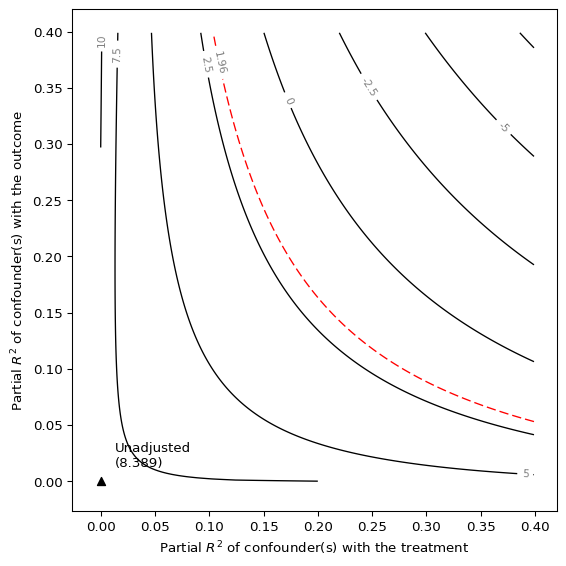

In [16]:
sense_nocov.plot(sensitivity_of = 't-value')

In [17]:
sense_cov = smkr.Sensemakr(
    model = res_ydx,
    treatment = "D",
    benchmark_covariates = ["X"],
    kd = [0.25, 0.5, 1]
)

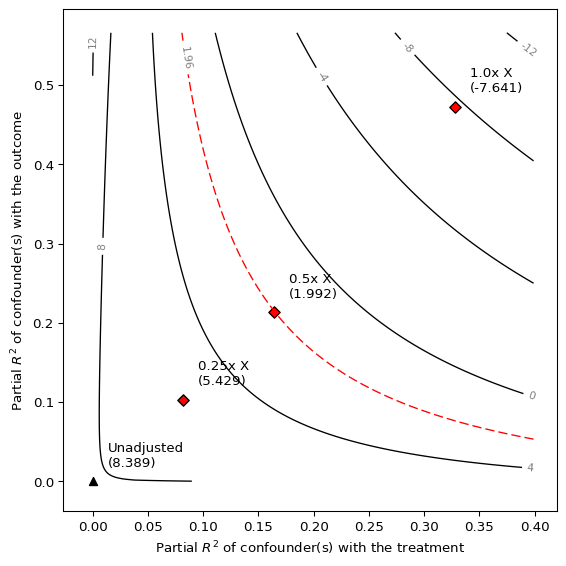

In [18]:
sense_cov.plot(sensitivity_of = 't-value')